# EDA dataset Google
La finalidad de este notebook es hacer una revisión de los datos actuales, realizar un EDA, para determinar un  SCOPE y posteriormente un ETL.
Vamos a trabajar con la libreria SPARK.

In [1]:
import os
os.environ["SPARK_HOME"] = r"F:\DataScience\spark\spark-3.5.3-bin-hadoop3\spark-3.5.3-bin-hadoop3"
os.environ["HADOOP_HOME"] = r"F:\DataScience\hadoop\hadoop-3.4.0"
os.environ["HADOOP_CONF_DIR"] = r"F:\DataScience\hadoop\hadoop-3.4.0\etc\hadoop"

import findspark
import pickle
import pandas as pd
import numpy as np


findspark.init()


from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[4]").config("spark.executor.memory", "8g").appName("PySpark").getOrCreate()
#para cerrar la sesión debemos usar spark.stop()

In [2]:
print(spark.version)

3.5.3


In [166]:
import re
from pyspark.sql.functions import explode
from pyspark.sql.functions import size, max as spark_max, min as spark_min, avg, isnan
from pyspark.sql.functions import col
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import sum, when
from pyspark.sql.functions import date_format, from_unixtime, year

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast


In [ ]:
# Creamos la lista de estados unicos en USA.
STATES_LIST = ['AZ', 'SC', 'LA', 'MN', 'NJ', 'DC', 'OR', 'VA', 'RI', 'KY', 'NH', 'MI', 'WY', 'FS', 'NW', 'NV', 'WI', 'ID', 'CA', 'NE', 'CT', 'MT', 'NC', 'MD', 'DE', 'MO', 'VT', 'IL', 'ME', 'WA', 'ND', 'MS', 'AL', 'IN', 'OH', 'TN', 'NM', 'IA', 'PA', 'SD', 'CR', 'US', 'NY', 'TX', 'WV', 'GA', 'MA', 'KS', '', 'CO', 'FL', 'AK', 'AR', 'OK', 'UT', 'HI', 'EW']

# Datos Google
Aqui tenemos basicamente dos datasets.

1. metadata-sitios: Metadata de todos los sites. Incluye cantidad de comentarios, descripcion, locación, categoria, rating promedio, etc.
2. review-estados: Cada uno de los reviews organizados por estado. Información relevante: usuario, texto, rating, gmap_id (id del negocio) 

## Metadata Sitios

In [4]:
ruta_lectura = r"F:\DataScience\PF - DataNova\datasets\Google Maps\metadata-sitios\1.json"

In [ ]:
df = spark.read.json(ruta_lectura)
# Considerar el uso de persist o cache
df_cached = df.cache()

In [6]:
#intentamos cargar todos los archivos.
#ruta_lectura_full = r"F:\DataScience\PF - DataNova\datasets\Google Maps\metadata-sitios\*.json"
#df_full = spark.read.json(ruta_lectura_full)
# este método no resulta eficiente, toma mas de 20 minutos en cargar todos los archivos.

In [7]:
# revision del df.
df_cached.show()

+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|                MISC|             address|avg_rating|            category|         description|             gmap_id|               hours|          latitude|          longitude|                name|num_of_reviews|price|    relative_results|               state|                 url|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|{[Wheelchair acce...|Porter Pharmacy, ...|       4.9|          [Pharmacy]|                NULL|0x88f16e41928ff68...|[[Friday, 8AM–6PM...|           32

In [372]:
# cantidad de filas.
df_cached.count()

275001

In [373]:
# Esquema de la tabla. total de 15 columnas
df_cached.printSchema()

root
 |-- MISC: struct (nullable = true)
 |    |-- Accessibility: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Activities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Amenities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Atmosphere: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Crowd: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Dining options: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- From the business: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Getting here: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health & safety: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Highlights: array (nullable = true)
 |    |

In [62]:
df_cached.describe().show()

+-------+--------------------+------------------+--------------------+--------------------+-------------------+-------------------+--------------------+------------------+-----+------------------+--------------------+
|summary|             address|        avg_rating|         description|             gmap_id|           latitude|          longitude|                name|    num_of_reviews|price|             state|                 url|
+-------+--------------------+------------------+--------------------+--------------------+-------------------+-------------------+--------------------+------------------+-----+------------------+--------------------+
|  count|              264939|            275001|               13155|              275001|             275001|             275001|              274994|            275001|13450|            195523|              275001|
|   mean|                NULL| 4.307215610124819|                NULL|                NULL|  37.49011244811361| -92.274707529695

In [374]:
# liberamos cache
df_cached.unpersist()

DataFrame[MISC: struct<Accessibility:array<string>,Activities:array<string>,Amenities:array<string>,Atmosphere:array<string>,Crowd:array<string>,Dining options:array<string>,From the business:array<string>,Getting here:array<string>,Health & safety:array<string>,Highlights:array<string>,Offerings:array<string>,Payments:array<string>,Planning:array<string>,Popular for:array<string>,Recycling:array<string>,Service options:array<string>>, address: string, avg_rating: double, category: array<string>, description: string, gmap_id: string, hours: array<array<string>>, latitude: double, longitude: double, name: string, num_of_reviews: bigint, price: string, relative_results: array<string>, state: string, url: string]

### 1st Look
1. Posibles columnas a remover: 
    - description: No proporciona data relevante. Solo 13155 de 275001 sites tienen un descripcion, es decir, menos del 5%.
    - state: No brinda información relevante para nuestro análisis. Solo información del estado (abierto o cerrado) del momento en el cual se extrajo la data.
    - url: Dirección url del sitio en google maps.
    - price: Demasiados valores nulos.
    - hours: Horarios de atención del negocio. (Evaluar remoción, a menos que sea necesario para el análisis.)

2. No poseemos información de la ciudad o el estado, podemos extraer de columna address.
3. Columnas clave: gmap_id, avg_rating, category.
4. MISC: Tiene un esquema definido. Importante validar que data puede ser de utilidad dentro de este esquema.
5. CATEGORY: Realizar un análisis de las categorías existentes. (i,e: Nube de palabras)

# EDA

Comenzazmos definiendo una función para extracción de datos relevantes para el EDA.

In [4]:
def metadata_analytics_treatment(spark_df):
    # Dropeado de columnas no utilizadas en nuestro EDA.
    spark_df_modified = spark_df.drop(*["description", "hours", "price", "state", "url", "MISC", "latitude", "longitude", "name", "relative_results"])

    # Anexamos la columna "state" en referencia al estado . ie. california: CA.
    state_regexp = r",\s([A-Z]{2})\s\d{5}"
    spark_df_modified = spark_df_modified.withColumn("state", regexp_extract("address", state_regexp, 1))
    spark_df_modified = spark_df_modified.dropna(subset="state") # Dropeamos nulos en esta columna.
    spark_df_modified = spark_df_modified.drop(*["address"]) # Dropeamos address, ya no lo necesitamos.

    # Dropeamos duplicados.
    spark_df_modified = spark_df_modified.dropDuplicates(["gmap_id"])
    
    return spark_df_modified

Creamos una rutina para leer y anexar todos los archivos.

In [ ]:
folder_path = r"F:\DataScience\PF - DataNova\datasets\Google Maps\metadata-sitios"

count_record = 0

for file_name in os.listdir(folder_path):
    
    # recuperamos el nombre de cada archivo.
    file_path = os.path.join(folder_path, file_name)
  
    # primera lectura: se toma el esquema y se fuerza en los demas archivos.
    if count_record == 0:
        df = spark.read.json(file_path)
        schema = df.schema
        df_ETLed = metadata_analytics_treatment(df)        
        union_df = df_ETLed.select("*")
    # lecturas posteriores: se fuerza esquema, se anexa dataframe.
    else:
        df = spark.read.schema(schema).json(file_path)
        df_ETLed = metadata_analytics_treatment(df)
        union_df = union_df.union(df_ETLed)

    count_record+=1
    print("Iteración: ", count_record)
    

Iteración:  1
Iteración:  2
Iteración:  3
Iteración:  4
Iteración:  5
Iteración:  6
Iteración:  7
Iteración:  8
Iteración:  9
Iteración:  10
Iteración:  11


In [6]:
# Total de 3millones de entradas. 
union_df.count()

2918918

In [377]:
union_df.describe().show()

+-------+------------------+--------------------+------------------+-------+
|summary|        avg_rating|             gmap_id|    num_of_reviews|  state|
+-------+------------------+--------------------+------------------+-------+
|  count|           2918918|             2918918|           2918918|2918918|
|   mean| 4.295948532983802|                NULL|44.133912292157575|   NULL|
| stddev|0.7113406120329981|                NULL|144.82764611758535|   NULL|
|    min|               1.0|0x0:0x117c7fa8223...|                 1|       |
|    max|               5.0|0xc221a717b87a13:...|              9998|     WY|
+-------+------------------+--------------------+------------------+-------+



In [378]:
union_df.printSchema()

root
 |-- avg_rating: double (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- gmap_id: string (nullable = true)
 |-- num_of_reviews: long (nullable = true)
 |-- state: string (nullable = true)



In [7]:
# Agrupamos por categorias
categories_df = union_df.select(explode("category").alias("category")).groupBy("category").count()
# Guardamos en cache
categories_df_cached = categories_df.cache()

In [361]:
# Top categorias
categories_df_cached.orderBy("count", ascending=False).show(truncate=False)

+------------------+-----+
|category          |count|
+------------------+-----+
|Restaurant        |96525|
|Auto repair shop  |77073|
|Gas station       |69668|
|Beauty salon      |64889|
|Convenience store |61629|
|Church            |52560|
|Hair salon        |51102|
|Nail salon        |44141|
|Park              |42142|
|ATM               |42019|
|Doctor            |36134|
|Clothing store    |35944|
|Dentist           |35714|
|Insurance agency  |35126|
|Barber shop       |34947|
|Grocery store     |31480|
|Bar               |30747|
|Cell phone store  |30305|
|Tourist attraction|29443|
|Tire shop         |29423|
+------------------+-----+
only showing top 20 rows



In [ ]:
# Total categorias 4461
categories_df_cached.count()

4461

In [ ]:
# liberamos memoria
categories_df_cached.unpersist()

DataFrame[category: string, count: bigint]

### Tratamiento de categorias
La problemática aquí es que tenemos cerca de 4461 categorías distintas, y debemos agruparlas de alguna manera en categorías que nos interesen

In [286]:
# Teniendo la data resumida , comenzamos a trabajar con pandas.
category_pddf = categories_df.toPandas()

In [ ]:
# Definimos una funcion para procesar texto , lemmatizar, tokenizar, remover caracteres especiales
# Evaluar remoción.
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Eliminar caracteres especiales
    text = text.lower()  # Minúsculas
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [ ]:
# Usaremos google cloud NLP content categorization. 
import os
from google.cloud import language_v1

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'F:\DataScience\PF - DataNova\gcp key\nomadic-bison-443616-m2-d5448cec0026.json'

client = language_v1.LanguageServiceClient()

def get_category(content):
   try:
      type_ = language_v1.Document.Type.PLAIN_TEXT
      language = "en"
      document = {"content": content, "type_": type_}
      categories = client.classify_text(document=document)
      return ([c.name for c in categories.categories])
   #return ([(c.name, round(c.confidence*100)) for c in    categories.categories])
   except Exception as e:
      return None

In [ ]:
# Creamos una nueva columna multiplicando 20 veces la columna categoria, ya que google necesita por lo menos 20 palabras para categorizar un texto.
category_pddf["expanded_category"] = (category_pddf["category"] + " " )* 20
category_pddf["expanded_category"] = category_pddf["expanded_category"].str.strip()

In [ ]:
# Aplicamos la funcion para categorizar. Tiempo de ejución 18mins.
google_categories = category_pddf["expanded_category"].apply(get_category)

In [ ]:
category_pddf["google_categories"] = google_categories
category_pddf.drop(columns=["expanded_category"], inplace=True)

# Visualización
category_pddf.head(20)

,category,count,google_categories
0,Art gallery,8545,[/Arts & Entertainment/Visual Art & Design/Art...
1,Public relations firm,396,[/Business & Industrial/Advertising & Marketin...
2,Tile store,3038,"[/Home & Garden/Home Improvement/Flooring, /Bu..."
3,Basketball club,209,[/Sports/Team Sports/Basketball]
4,Sports massage therapist,3735,[/Beauty & Fitness/Spas & Beauty Services/Mass...
5,Dry wall contractor,1199,[/Business & Industrial/Construction & Mainten...
6,Debt collecting,68,[/Finance/Credit & Lending]
7,Taxicab Stand,80,[/Travel/Car Rental & Taxi Services]
8,Leather coats store,47,[/Shopping/Apparel]
9,Law book store,9,[/Law & Government/Legal]


In [275]:
#exploramos los valores nulos
category_pddf[category_pddf["google_categories"].isnull()]

,category,count,google_categories
175,Allergist,1205,None
268,Parking Souterrain,1,None
1787,Hat shop,1498,None
2700,Tool & die shop,79,None
2796,Assistante maternelle,1,None
3494,Guardia Di Finanza Police,1,None
3667,Brasserie,57,None
4135,Bar tabac,7,None


In [ ]:
# Agregamos manualmente las categorias de interes, y dropeamos las demás.
category_pddf.loc[3667, "google_categories"] = ['/Food & Drink/Beverages/Alcoholic Beverages']
category_pddf.loc[175, "google_categories"] = ['/Health/Medical Facilities & Services']
category_pddf.loc[1787, "google_categories"] = ["/Shopping/Apparel/Headwear"]
category_pddf.loc[4135, "google_categories"] = ["/Arts & Entertainment/Events & Listings/Bars, Clubs & Nightlife"]
category_pddf.loc[2700, "google_categories"] = ["/Home & Garden/Home Appliances/Other"]
category_pddf.dropna(subset="google_categories", inplace=True)


In [ ]:
# Tratamiento sobre la columna "google_categories", para poder obtener un árbol de categorias para cada categoria.
category_pddf["first_match"] = category_pddf["google_categories"].apply(lambda x : x[0] if x else x)
category_pddf["category_segmentation"] = category_pddf["first_match"].str.split("/")
category_pddf.dropna(subset="category_segmentation", inplace=True)
category_pddf["category_len"] = category_pddf["category_segmentation"].apply(len)
category_pddf["first_category"] = category_pddf["category_segmentation"].apply(lambda x : x[1] if x[1] else None)
category_pddf["second_category"] = category_pddf["category_segmentation"].apply(lambda x : x[2] if len(x)>2 else None)
category_pddf["third_category"] = category_pddf["category_segmentation"].apply(lambda x : x[3] if len(x)>3 else None)

In [ ]:
category_pddf_mapped = category_pddf[["category", "first_category", "second_category", "third_category"]]
# guardamos este dataset. 
category_pddf_mapped.to_json(r"F:\DataScience\PF - DataNova\datasets\Google Maps\category-mapping.json", index=False)

In [ ]:
# visualización.
category_pddf_mapped.head(5)

,category,first_category,second_category,third_category
0,Art gallery,Arts & Entertainment,Visual Art & Design,Art Museums & Galleries
1,Public relations firm,Business & Industrial,Advertising & Marketing,Public Relations
2,Tile store,Home & Garden,Home Improvement,Flooring
3,Basketball club,Sports,Team Sports,Basketball
4,Sports massage therapist,Beauty & Fitness,Spas & Beauty Services,Massage Therapy


In [ ]:
# Tenemos un total de 27 categorias.
category_pddf_mapped["first_category"].unique()

array(['Arts & Entertainment', 'Business & Industrial', 'Home & Garden',
       'Sports', 'Beauty & Fitness', 'Finance', 'Travel', 'Shopping',
       'Law & Government', 'People & Society', 'Food & Drink', 'Health',
       'Autos & Vehicles', 'Hobbies & Leisure', 'Real Estate',
       'Computers & Electronics', 'Jobs & Education', 'Games', 'Science',
       'Sensitive Subjects', 'News', 'Reference', 'Internet & Telecom',
       'Books & Literature', 'Adult', 'Pets & Animals',
       'Online Communities'], dtype=object)

### Cruce con Categorias de Google

In [36]:
ruta_lectura = r"F:\DataScience\PF - DataNova\datasets\Google Maps\metadata-sitios\1.json"
df = spark.read.json(ruta_lectura)
# Considerar el uso de persist o cache
df_cached = df.cache()
union_df = metadata_analytics_treatment(df_cached)

In [ ]:
# cargamos en memoria el dataframe union_df
union_df_cache = union_df.cache()

In [8]:
union_df_cache.show(20, truncate=False)

+----------+--------------------------------------------------------------------------------------------------------+-------------------------------------+--------------+-----+
|avg_rating|category                                                                                                |gmap_id                              |num_of_reviews|state|
+----------+--------------------------------------------------------------------------------------------------------+-------------------------------------+--------------+-----+
|5.0       |[Business to business service]                                                                          |0x405532c73fa7ce23:0x543f583f2cf17d6f|4             |OR   |
|4.3       |[Consignment shop]                                                                                      |0x4108fee3fd360515:0x526ea25588b1bebf|8             |WA   |
|3.8       |[Credit union, ATM, Car finance and loan company, Federal credit union, Financial institution]         

In [9]:
union_df_cache.printSchema()

root
 |-- avg_rating: double (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- gmap_id: string (nullable = true)
 |-- num_of_reviews: long (nullable = true)
 |-- state: string (nullable = true)



In [50]:
# 1 . Ya que cada establecimiento tiene una lista de categorias, vamos a observar las características de estas listas de categorias.
stats = (
    union_df_cache.select(size(col("category")).alias("array_size"))  # Calcula el tamaño de cada array
      .agg(
          spark_min(col("array_size")).alias("min_size"),       # max
          spark_max(col("array_size")).alias("max_size"),        # Tamaño máximo
          avg(col("array_size")).alias("avg_size")        # tamaño promedio.-
          )       
      .collect()[0]                          
)

In [51]:
stats

Row(min_size=-1, max_size=32, avg_size=2.0449793382342363)

In [10]:
# Para simplicidad del análisis, tomaremos la primera categoria de cada establecimiento.
union_df_cache = union_df_cache.withColumn("primary_category", col("category")[0])
union_df_cache = union_df_cache.drop("category")
union_df_cache.show()

+----------+--------------------+--------------+-----+--------------------+
|avg_rating|             gmap_id|num_of_reviews|state|    primary_category|
+----------+--------------------+--------------+-----+--------------------+
|       5.0|0x405532c73fa7ce2...|             4|   OR|Business to busin...|
|       4.3|0x4108fee3fd36051...|             8|   WA|    Consignment shop|
|       3.8|0x4cad876f48719ba...|            24|   ME|        Credit union|
|       5.0|0x4cae4b5f86d43b0...|             1|   ME|                Cafe|
|       4.4|0x4cb1169012dc644...|             5|   ME|     Natural feature|
|       5.0|0x4cca89c9f77c14a...|             3|   NY|United Methodist ...|
|       3.8|0x4d524b86892e26b...|             4|   MI|     Furniture store|
|       4.6|0x4d533c5bd35bad9...|            18|   WI|         Gas station|
|       3.0|0x4d57aaa64a456b2...|             2|   MI|               River|
|       4.1|0x52ae4da3353914d...|            24|   MN|        Truck dealer|
|       3.0|

In [11]:
# cargamos nuestro dataset de mapeo con spark para poder hacer uniones.
#category_pddf_mapped = pd.read_json(r"F:\DataScience\PF - DataNova\datasets\Google Maps\category-mapping.json")
#category_pddf_mapped.to_json(r"F:\DataScience\PF - DataNova\datasets\Google Maps\category-mapping-v2.json",orient="records", lines=True)
#category_mapper_df = spark.createDataFrame(category_pddf_mapped[["category", "first_category"]])

category_mapper_df = spark.read.json(r"F:\DataScience\PF - DataNova\datasets\Google Maps\category-mapping-v2.json")
category_mapper_df_cached = category_mapper_df.cache()
category_mapper_df_cached.count()

4202

In [12]:
category_mapper_df_cached = category_mapper_df_cached.withColumnRenamed("category", "primary_category")
#category_mapper_df_cached = category_mapper_df.cache()
#category_mapper_df.show()

In [13]:
category_mapper_df_cached.show()

+--------------------+--------------------+--------------------+--------------------+
|    primary_category|      first_category|     second_category|      third_category|
+--------------------+--------------------+--------------------+--------------------+
|         Art gallery|Arts & Entertainment| Visual Art & Design|Art Museums & Gal...|
|Public relations ...|Business & Indust...|Advertising & Mar...|    Public Relations|
|          Tile store|       Home & Garden|    Home Improvement|            Flooring|
|     Basketball club|              Sports|         Team Sports|          Basketball|
|Sports massage th...|    Beauty & Fitness|Spas & Beauty Ser...|     Massage Therapy|
| Dry wall contractor|Business & Indust...|Construction & Ma...|                NULL|
|     Debt collecting|             Finance|    Credit & Lending|                NULL|
|       Taxicab Stand|              Travel|Car Rental & Taxi...|                NULL|
| Leather coats store|            Shopping|           

In [14]:
merged_df = union_df_cache.join(category_mapper_df_cached, on="primary_category", how="inner")

In [ ]:
# indicamos que vamos a cargar este valor en cache.
merged_df_cache = merged_df.cache()

In [ ]:
# liberamos la data usada previamente
category_mapper_df_cached.unpersist()
union_df_cache.unpersist()

DataFrame[avg_rating: double, gmap_id: string, num_of_reviews: bigint, state: string, primary_category: string]

In [34]:
merged_df_cache.show()

+--------------------+----------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|    primary_category|avg_rating|             gmap_id|num_of_reviews|state|      first_category|     second_category|      third_category|
+--------------------+----------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|Business to busin...|       5.0|0x405532c73fa7ce2...|             4|   OR|Business & Indust...|                NULL|                NULL|
|    Consignment shop|       4.3|0x4108fee3fd36051...|             8|   WA|            Shopping|                NULL|                NULL|
|        Credit union|       3.8|0x4cad876f48719ba...|            24|   ME|             Finance|    Credit & Lending|                NULL|
|                Cafe|       5.0|0x4cae4b5f86d43b0...|             1|   ME|        Food & Drink|         Restaurants|                NULL|
|United Methodist ...|     

In [18]:
merged_df_cache.count()

2838112

In [35]:
#Ahora podemos usar este dataframe para nuestro análisis

## Cantidad de Negocios por estado

In [51]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns


In [38]:
grouped_df = merged_df_cache.groupBy("state").agg(F.sum("num_of_reviews").alias("total_reviews"),
                                     F.avg("avg_rating").alias("avg_rating"),
                                     F.count("gmap_id").alias("total_business"))

In [ ]:
state_resume = grouped_df.toPandas()

In [49]:
filter = (state_resume["total_reviews"]>1000) & (state_resume["state"]!="")
filtered_state_resume = state_resume[filter]
filtered_state_resume

,state,total_reviews,avg_rating,total_business
0,AZ,3057916,4.270468,57978
1,SC,2089391,4.324197,46448
2,LA,1490424,4.309179,37051
3,MN,1871368,4.333401,46987
4,NJ,3496696,4.284701,74671
5,DC,311209,4.134979,6298
6,OR,1797574,4.317996,43370
7,VA,3266333,4.278711,67482
8,RI,385016,4.343500,8984
9,KY,1388936,4.296188,36491


In [53]:
# Observamos valores atípicos en las columnas total_reviews y total_business, posiblemente estados con mayor cantidad de habitantes o con mayor actividad económica.
filtered_state_resume.describe()

,total_reviews,avg_rating,total_business
count,5.100000e+01,51.000000,51.000000
mean,2.459587e+06,4.310660,55112.803922
std,2.881908e+06,0.052009,59491.520114
min,2.025520e+05,4.134979,6298.000000
25%,6.332645e+05,4.284252,16220.000000
50%,1.679487e+06,4.315797,39405.000000
75%,2.985290e+06,4.338050,64195.000000
max,1.333165e+07,4.413362,286846.000000


<Axes: ylabel='total_reviews'>

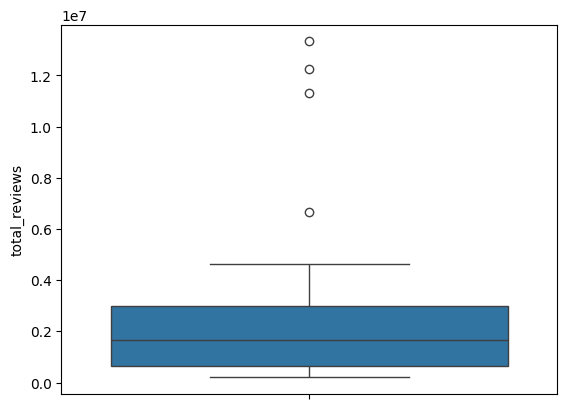

In [55]:
sns.boxplot(data=filtered_state_resume["total_reviews"])

<Axes: xlabel='state', ylabel='total_reviews'>

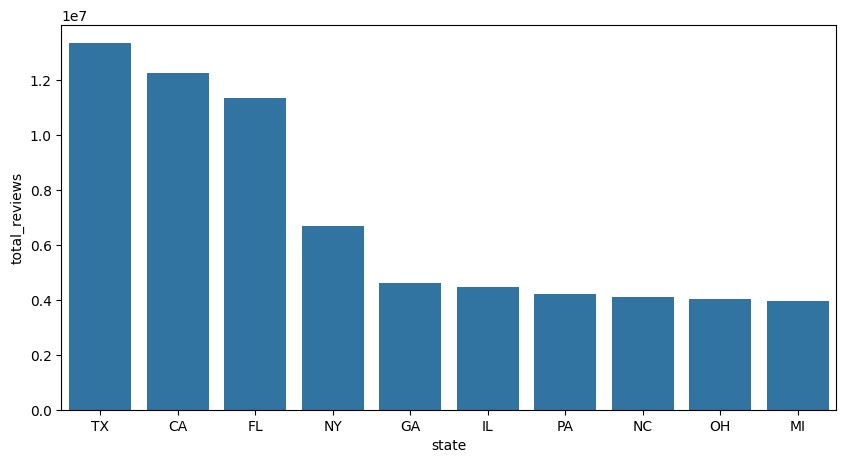

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(data= filtered_state_resume.sort_values(by="total_reviews", ascending=False).head(10), y="total_reviews", x= "state") 
#Los estados con mayor cantidad de reviews son Texas, California, Florida y New York.

<Axes: ylabel='total_business'>

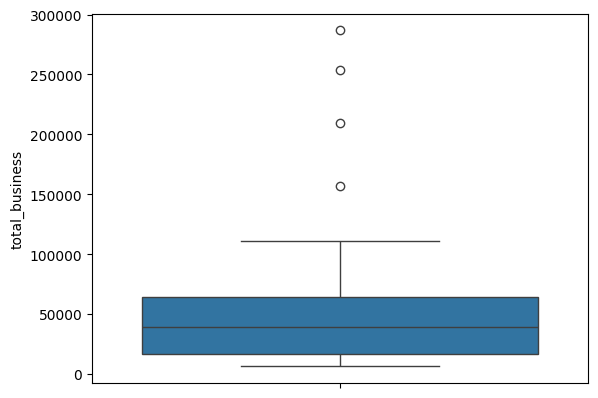

In [56]:
sns.boxplot(data=filtered_state_resume["total_business"])

<Axes: xlabel='state', ylabel='total_business'>

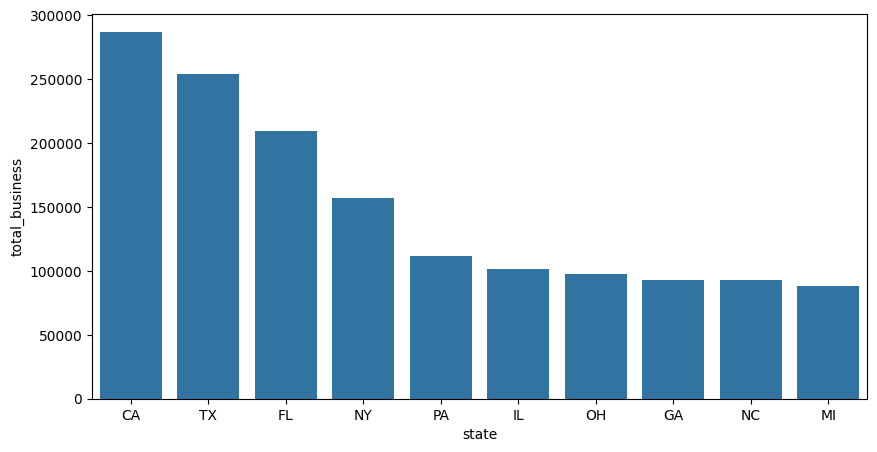

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(data= filtered_state_resume.sort_values(by="total_business", ascending=False).head(10), y="total_business", x= "state") 
#Nuevamente se repiten los mismos estados: Texas, California, Florida y New York.

<Axes: ylabel='avg_rating'>

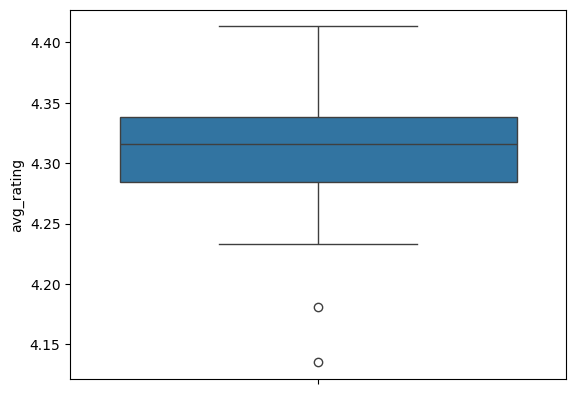

In [ ]:
sns.boxplot(data=filtered_state_resume["avg_rating"])
# Vemos que existen dos estados con ratings por debajo de la media.

<Axes: xlabel='avg_rating', ylabel='state'>

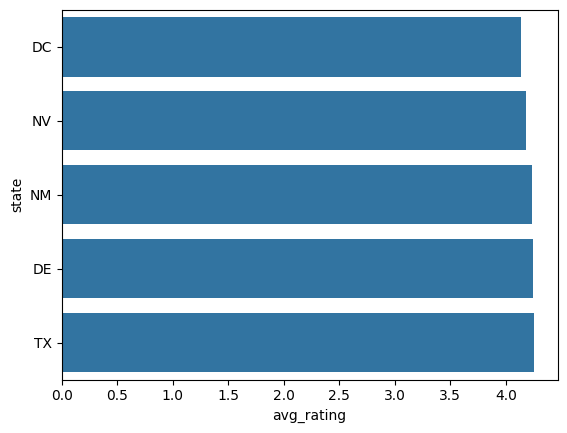

In [ ]:
sns.barplot(data= filtered_state_resume.sort_values(by="avg_rating", ascending=True).head(5), x="avg_rating", y= "state") 
# Los estados con menor puntuacion: Distrito de Columbia, y Nevada.

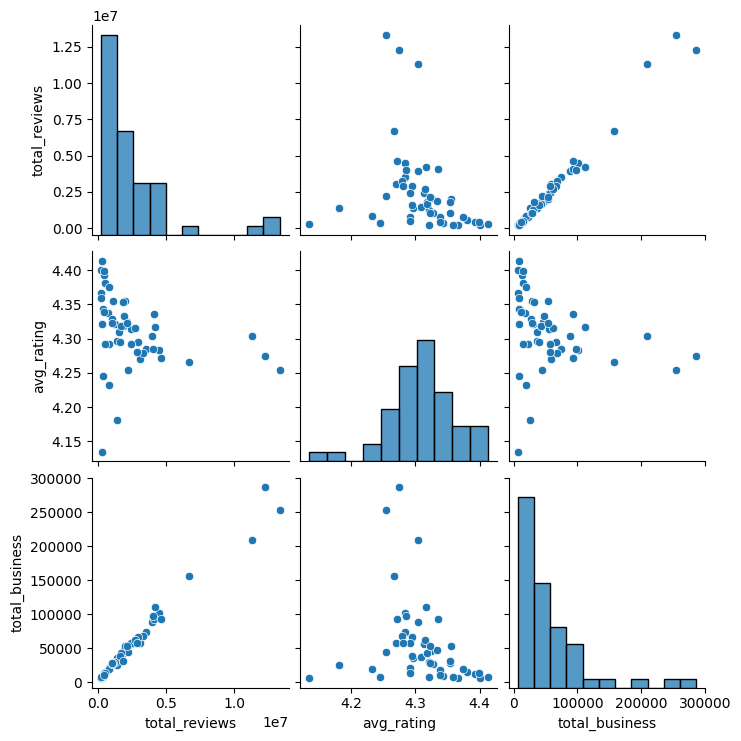

In [79]:
sns.pairplot(data=filtered_state_resume)

In [80]:
# Aqui solo observamos una correlación entre total_business y total_reviews, como era de esperarse.

# Análisis por Categoría de Negocio

In [82]:
merged_df_cache.show()

+--------------------+----------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|    primary_category|avg_rating|             gmap_id|num_of_reviews|state|      first_category|     second_category|      third_category|
+--------------------+----------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|Business to busin...|       5.0|0x405532c73fa7ce2...|             4|   OR|Business & Indust...|                NULL|                NULL|
|    Consignment shop|       4.3|0x4108fee3fd36051...|             8|   WA|            Shopping|                NULL|                NULL|
|        Credit union|       3.8|0x4cad876f48719ba...|            24|   ME|             Finance|    Credit & Lending|                NULL|
|                Cafe|       5.0|0x4cae4b5f86d43b0...|             1|   ME|        Food & Drink|         Restaurants|                NULL|
|United Methodist ...|     

In [83]:
category_grouped_df = merged_df_cache.groupBy("first_category", "second_category", "third_category").agg(
    F.sum("num_of_reviews").alias("total_reviews"),
    F.avg("avg_rating").alias("avg_rating"),
    F.count("gmap_id").alias("total_business")
)

In [84]:
category_resume = category_grouped_df.toPandas()

In [89]:
category_resume.sort_values(by=["first_category", "second_category", "third_category"]).head(20)

,first_category,second_category,third_category,total_reviews,avg_rating,total_business
230,Adult,None,None,81339,3.836600,1612
320,Arts & Entertainment,Comics & Animation,Anime & Manga,38,4.420000,5
63,Arts & Entertainment,Comics & Animation,Comics,60995,4.512620,832
391,Arts & Entertainment,Entertainment Industry,Film & TV Industry,16306,4.692372,1311
220,Arts & Entertainment,Entertainment Industry,Recording Industry,71524,4.698433,2489
158,Arts & Entertainment,Entertainment Industry,None,12827,4.468257,482
376,Arts & Entertainment,Events & Listings,"Bars, Clubs & Nightlife",1426183,4.274775,24765
278,Arts & Entertainment,Events & Listings,Concerts & Music Festivals,76921,4.469712,1248
265,Arts & Entertainment,Events & Listings,Expos & Conventions,62943,4.324373,1116
218,Arts & Entertainment,Events & Listings,Movie Listings & Theater Showtimes,2345,4.500000,7


In [91]:
# 
grouped_df = category_resume.groupby("first_category").apply(
    lambda group: pd.Series({
        "weighted_avg_rating": (group["total_reviews"] * group["avg_rating"]).sum() / group["total_reviews"].sum(),
        "total_reviews": group["total_reviews"].sum(),
        "total_business": group["total_business"].sum()
    })
).reset_index()

C:\Users\Une\AppData\Local\Temp\ipykernel_6384\1889549603.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df = category_resume.groupby("first_category").apply(


In [92]:
grouped_df

,first_category,weighted_avg_rating,total_reviews,total_business
0,Adult,3.836600,81339.0,1612.0
1,Arts & Entertainment,4.380648,3569775.0,82317.0
2,Autos & Vehicles,4.343066,11491759.0,222610.0
3,Beauty & Fitness,4.476816,10533556.0,230793.0
4,Books & Literature,4.423077,214207.0,3780.0
5,Business & Industrial,4.163736,11454080.0,407129.0
6,Computers & Electronics,4.177554,2480353.0,49073.0
7,Finance,4.258909,3601778.0,109800.0
8,Food & Drink,4.173802,30233912.0,358880.0
9,Games,4.291946,463076.0,6516.0


<Axes: xlabel='total_reviews', ylabel='first_category'>

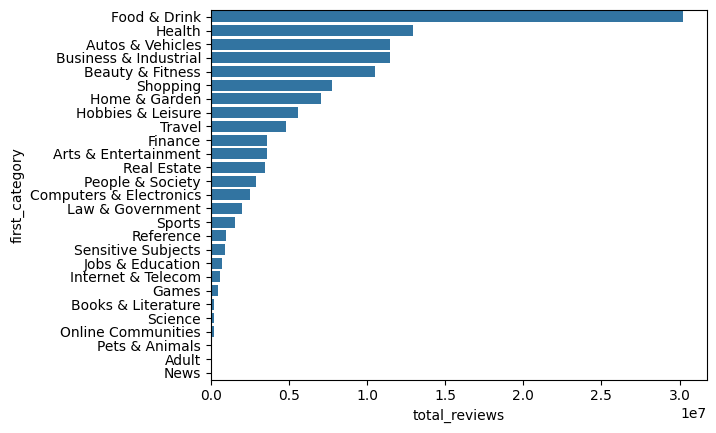

In [95]:
sns.barplot(data=grouped_df.sort_values(by="total_reviews", ascending=False), x="total_reviews", y="first_category")

<Axes: xlabel='total_business', ylabel='first_category'>

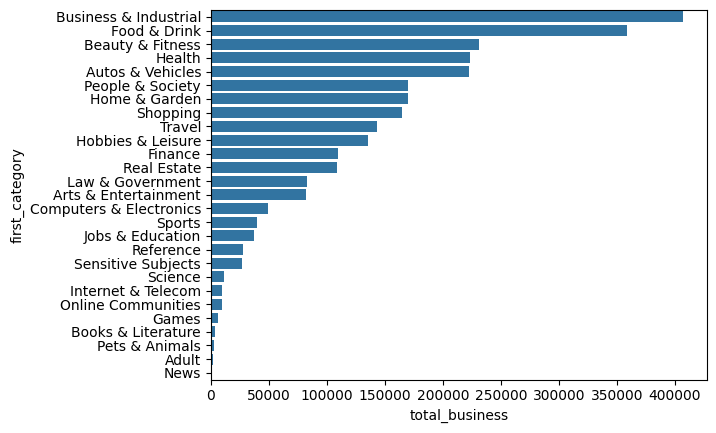

In [96]:
sns.barplot(data=grouped_df.sort_values(by="total_business", ascending=False), x="total_business", y="first_category")

Observamos que los negocios con mayor cantidad de establecimientos y reviews son:
- Business & Industrial
- Food & Drink
- Beauty & Fitness
- Heakth
- Autos & Vehicles
- People & Society
- Home & Garden
- Shopping
- Travel
- Hobbies & Leisure

In [99]:
grouped_df.describe()

,weighted_avg_rating,total_reviews,total_business
count,27.000000,2.700000e+01,27.000000
mean,4.275177,4.659189e+06,105115.259259
std,0.186380,6.489113e+06,110556.076716
min,3.836600,1.107300e+04,868.000000
25%,4.168769,5.122685e+05,10611.000000
50%,4.297061,2.480353e+06,82317.000000
75%,4.420269,6.316591e+06,167433.500000
max,4.550029,3.023391e+07,407129.000000


In [101]:
grouped_df[grouped_df["weighted_avg_rating"]<4.1]

,first_category,weighted_avg_rating,total_reviews,total_business
0,Adult,3.836600,81339.0,1612.0
20,Real Estate,3.897618,3441782.0,109071.0
23,Sensitive Subjects,3.950809,934097.0,26749.0


In [102]:
grouped_df[grouped_df["weighted_avg_rating"]>4.4]

,first_category,weighted_avg_rating,total_reviews,total_business
3,Beauty & Fitness,4.476816,10533556.0,230793.0
4,Books & Literature,4.423077,214207.0,3780.0
11,Hobbies & Leisure,4.517523,5553273.0,135200.0
12,Home & Garden,4.417462,7079909.0,169808.0
18,People & Society,4.550029,2900114.0,170356.0
21,Reference,4.477579,983557.0,27994.0
22,Science,4.476008,185604.0,11171.0
25,Sports,4.440723,1535546.0,40160.0


## Analisis por sub-categoria

In [130]:
grouped_df = category_resume.groupby(["first_category", "second_category"]).apply(
    lambda group: pd.Series({
        "weighted_avg_rating": (group["total_reviews"] * group["avg_rating"]).sum() / group["total_reviews"].sum(),
        "total_reviews": group["total_reviews"].sum(),
        "total_business": group["total_business"].sum()
    })
).reset_index()

C:\Users\Une\AppData\Local\Temp\ipykernel_6384\3673612760.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df = category_resume.groupby(["first_category", "second_category"]).apply(


In [131]:
grouped_df

,first_category,second_category,weighted_avg_rating,total_reviews,total_business
0,Arts & Entertainment,Comics & Animation,4.512563,61033.0,837.0
1,Arts & Entertainment,Entertainment Industry,4.668119,100657.0,4282.0
2,Arts & Entertainment,Events & Listings,4.303666,2020417.0,32562.0
3,Arts & Entertainment,Humor,4.437634,12805.0,186.0
4,Arts & Entertainment,Movies,4.209890,446099.0,6532.0
...,...,...,...,...,...
163,Travel,Car Rental & Taxi Services,3.692413,513663.0,7539.0
164,Travel,Cruises & Charters,4.372093,35367.0,645.0
165,Travel,Hotels & Accommodations,4.179690,386604.0,17244.0
166,Travel,Specialty Travel,4.666306,121178.0,3416.0


In [132]:
grouped_df.sort_values(by="total_business",ascending=False).head(30)

,first_category,second_category,weighted_avg_rating,total_reviews,total_business
61,Food & Drink,Restaurants,4.139928,17690919.0,165140.0
15,Autos & Vehicles,Vehicle Parts & Services,4.402566,7284934.0,164739.0
122,People & Society,Religion & Belief,4.648761,1797032.0,119582.0
44,Business & Industrial,Transportation & Logistics,4.045280,3592619.0,99429.0
167,Travel,Tourist Destinations,4.411280,3356326.0,91414.0
72,Health,Medical Facilities & Services,4.024154,4126364.0,86573.0
145,Shopping,Apparel,4.279559,3093669.0,84222.0
24,Beauty & Fitness,Spas & Beauty Services,4.579755,2685022.0,77920.0
35,Business & Industrial,Energy & Utilities,3.928432,2244236.0,77675.0
129,Real Estate,Real Estate Listings,3.747694,2333272.0,68670.0


<Axes: xlabel='total_business', ylabel='second_category'>

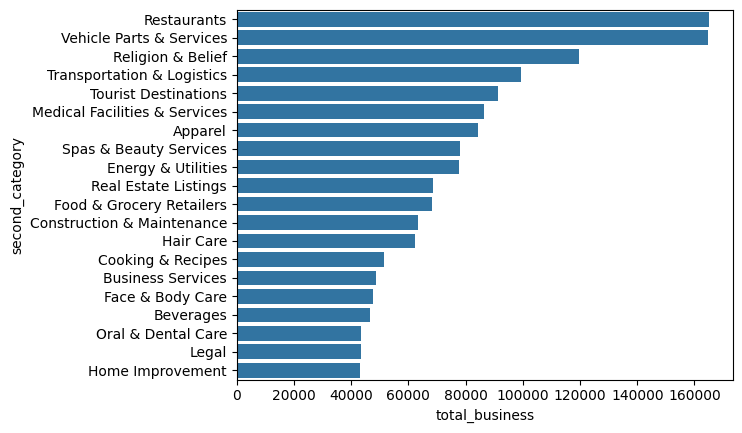

In [134]:
sns.barplot(data=grouped_df.sort_values(by="total_business", ascending=False).head(20), x="total_business", y="second_category")

A nivel de 2da categoria, los restaurantes son los que tienen mayor cantidad de negocios. Otro negocio que nos puede interesar: Beverages.

In [135]:
# Pendiente mayor revision de categorias.

In [ ]:
# Reviews spark cache
cached_rdds = spark.sparkContext._jsc.getPersistentRDDs()
for rdd_id, rdd in cached_rdds.items():
    print(f"RDD ID: {rdd_id}, Name: {rdd.name()}")

In [ ]:
# Clear sparks cache.
spark.catalog.clearCache()

# Dataset reviews

Hay que tener en cuenta que la estructura de archivos de path esta segmentada por Estados.

In [141]:
reviews_path = r"F:\DataScience\PF - DataNova\datasets\Google Maps\reviews-estados"

In [143]:
folders = [name for name in os.listdir(reviews_path) if os.path.isdir(os.path.join(reviews_path, name))]
len(folders)

51

## Estrategia

Debido a que son 51 estados y cerca de 24 gigas en total, información que no podemos cargar en memoria, vamos a crear un plan de analisis por estado y luego resumir data con técnicas de agregación por estado

#### Analisis de esquema
Vamos a cargar data de 1 de los estados con el fin de validar su esquema, estructura, y determinar columnas relevantes y prescindibles

In [148]:
# Definimos un file para leer.
files_path = reviews_path+ "\\" + folders[5] 
files_path

'F:\\DataScience\\PF - DataNova\\datasets\\Google Maps\\reviews-estados\\review-Colorado'

In [165]:
# Rutina para leer archivos dentro de la carpeta.

def batch_file_read(folder_path):
    "Lee varios archivos JSON dentro de una carpeta especifica, output: Dataframe Spark."
    count_record = 0

    for file_name in os.listdir(folder_path):
        
        # recuperamos el nombre de cada archivo.
        file_path = os.path.join(folder_path, file_name)
    
        # primera lectura: se toma el esquema y se fuerza en los demas archivos.
        if count_record == 0:
            df = spark.read.json(file_path)
            schema = df.schema      
            union_df = df.select("*")
        # lecturas posteriores: se fuerza esquema, se anexa dataframe.
        else:
            df = spark.read.schema(schema).json(file_path)
            union_df = union_df.union(df)

        count_record+=1
        print("Iteración: ", count_record)
    
    return union_df

In [152]:
reviews_df = batch_file_read(files_path)

Iteración:  1
Iteración:  2
Iteración:  3
Iteración:  4
Iteración:  5
Iteración:  6
Iteración:  7
Iteración:  8
Iteración:  9
Iteración:  10
Iteración:  11
Iteración:  12
Iteración:  13
Iteración:  14
Iteración:  15
Iteración:  16


In [153]:
# cargamos en memoria
reviews_df.cache()

DataFrame[gmap_id: string, name: string, pics: array<struct<url:array<string>>>, rating: bigint, resp: struct<text:string,time:bigint>, text: string, time: bigint, user_id: string]

In [ ]:
reviews_df.printSchema()
# Esquema.

root
 |-- gmap_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- pics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- url: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |-- rating: long (nullable = true)
 |-- resp: struct (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- time: long (nullable = true)
 |-- text: string (nullable = true)
 |-- time: long (nullable = true)
 |-- user_id: string (nullable = true)



In [ ]:
reviews_df.count()
#Tenemos 2,4 millones de entradas.

2400000

In [156]:
reviews_df.show()

+--------------------+--------------------+----+------+--------------------+--------------------+-------------+--------------------+
|             gmap_id|                name|pics|rating|                resp|                text|         time|             user_id|
+--------------------+--------------------+----+------+--------------------+--------------------+-------------+--------------------+
|0x876c75945568003...|         mgshouldice|NULL|     3|                NULL|Don't mix this up...|1484353876202|10899045731676311...|
|0x876c75945568003...|   Sabrina Holsinger|NULL|     4|                NULL|Teachers are grea...|1484195642287|10740396647478613...|
|0x876c75945568003...|           Tad Amore|NULL|     5|                NULL|Great school can'...|1459554530689|11281981894504357...|
|0x876c75945568003...|Victoria Elizabet...|NULL|     1|                NULL|                NULL|1483746469128|10259175743371735...|
|0x876c75945568003...|   Luis Garcia-Lopez|NULL|     5|              

### 1st Look
- Columnas a remover para nuestro análisis EDA: 
    - name (nombre del usuario)
    - user_id (id del usuario)
    - pics (fotos)
    - resp (respuestas al review): se puede usar luego para sentiment analysis
    - text (texto del comentario del usuario): se puede usar luego para sentiment analysis

In [157]:
reviews_df_modified = reviews_df.drop(*["name", "pics", "user_id", "resp", "text"])

In [158]:
reviews_df_modified.show()

+--------------------+------+-------------+
|             gmap_id|rating|         time|
+--------------------+------+-------------+
|0x876c75945568003...|     3|1484353876202|
|0x876c75945568003...|     4|1484195642287|
|0x876c75945568003...|     5|1459554530689|
|0x876c75945568003...|     1|1483746469128|
|0x876c75945568003...|     5|1542782383361|
|0x876c87f681db8d4...|     5|1627648451803|
|0x876c87f681db8d4...|     5|1605626911038|
|0x876c87f681db8d4...|     5|1583596411489|
|0x876c87f681db8d4...|     5|1560913666996|
|0x876c87f681db8d4...|     5|1584141376219|
|0x876c87f681db8d4...|     5|1591937054740|
|0x876c87f681db8d4...|     5|1590616553639|
|0x876c87f681db8d4...|     5|1562819795661|
|0x876c87f681db8d4...|     5|1566699647491|
|0x876b81ca88f8746...|     4|1629216800001|
|0x876b81ca88f8746...|     5|1600879831188|
|0x876b81ca88f8746...|     5|1532650560967|
|0x876b81ca88f8746...|     5|1532650605298|
|0x876b81ca88f8746...|     4|1558622836438|
|0x876b81ca88f8746...|     5|152

In [ ]:
reviews_df_modified.select([F.count(when(isnan(c), c)).alias(c) for c in reviews_df_modified.columns]).show()
# Sin valores nulos

+-------+------+----+
|gmap_id|rating|time|
+-------+------+----+
|      0|     0|   0|
+-------+------+----+



In [168]:
# Conversion de la columna time a un formato de fecha
reviews_df_modified = reviews_df_modified.withColumn("formatted_time", from_unixtime(col("time") / 1000))
reviews_df_modified = reviews_df_modified.withColumn("year", year(col("formatted_time")))

In [ ]:
# Visualizacion,
reviews_df_modified.show()

+--------------------+------+-------------+-------------------+----+
|             gmap_id|rating|         time|     formatted_time|year|
+--------------------+------+-------------+-------------------+----+
|0x876c75945568003...|     3|1484353876202|2017-01-13 19:31:16|2017|
|0x876c75945568003...|     4|1484195642287|2017-01-11 23:34:02|2017|
|0x876c75945568003...|     5|1459554530689|2016-04-01 18:48:50|2016|
|0x876c75945568003...|     1|1483746469128|2017-01-06 18:47:49|2017|
|0x876c75945568003...|     5|1542782383361|2018-11-21 01:39:43|2018|
|0x876c87f681db8d4...|     5|1627648451803|2021-07-30 07:34:11|2021|
|0x876c87f681db8d4...|     5|1605626911038|2020-11-17 10:28:31|2020|
|0x876c87f681db8d4...|     5|1583596411489|2020-03-07 10:53:31|2020|
|0x876c87f681db8d4...|     5|1560913666996|2019-06-18 22:07:46|2019|
|0x876c87f681db8d4...|     5|1584141376219|2020-03-13 18:16:16|2020|
|0x876c87f681db8d4...|     5|1591937054740|2020-06-11 23:44:14|2020|
|0x876c87f681db8d4...|     5|15906

In [174]:
# Ahora podemos agrupar por año para visualizar la evolución en este estado.
reviews_df_agg = reviews_df_modified.groupBy("year").agg(
    avg("rating").alias("avg_rating"),
    F.count("gmap_id").alias("total_reviews")
)

In [175]:
reviews_df_agg.show()

+----+------------------+-------------+
|year|        avg_rating|total_reviews|
+----+------------------+-------------+
|2018| 4.259524745399321|       559700|
|2015|3.9261709907713738|        22972|
|2013| 3.964925100474973|         5474|
|2014|3.9490288404944085|         8495|
|2019| 4.307230048850508|       691088|
|2020| 4.365693578741993|       463336|
|2012| 4.102533460803059|         4184|
|2009|3.5304347826086957|          115|
|2016|4.0810251481031035|       101956|
|2010|3.7639553429027113|          627|
|2011|3.9607379375591294|         2114|
|2008|3.8974358974358974|           39|
|2017| 4.186101191695637|       317279|
|2021|  4.40108621433192|       222608|
|2007|3.5454545454545454|           11|
|1990|               4.0|            2|
+----+------------------+-------------+



In [176]:
#Pasamos a pandas para poder graficar con seaborn.
reviews_pd_df = reviews_df_agg.toPandas()

In [182]:
reviews_pd_df = reviews_pd_df.sort_values(by="year", ascending=False).reset_index(drop=True)

<Axes: xlabel='year', ylabel='total_reviews'>

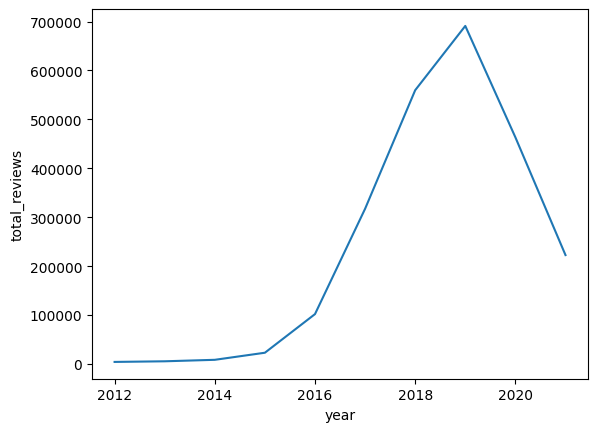

In [184]:
sns.lineplot(data=reviews_pd_df.head(10), x="year", y="total_reviews")

<Axes: xlabel='year', ylabel='avg_rating'>

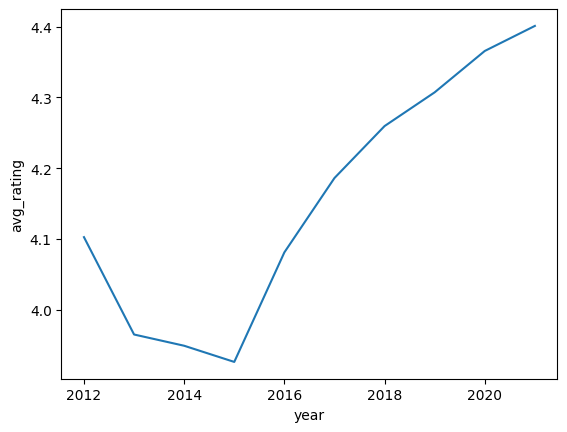

In [185]:
sns.lineplot(data=reviews_pd_df.head(10), x="year", y="avg_rating")

## Cruce con restaurantes

# Finalización tarea de Spark

In [53]:
spark.stop()